## Wide-narrow drops + slopes

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy import optimize as optim

import sys
sys.path.append('Library/')

import drop_detection_tools as ddt


from tqdm import tqdm
%matplotlib inline

In [ ]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<Figure size 432x288 with 0 Axes>

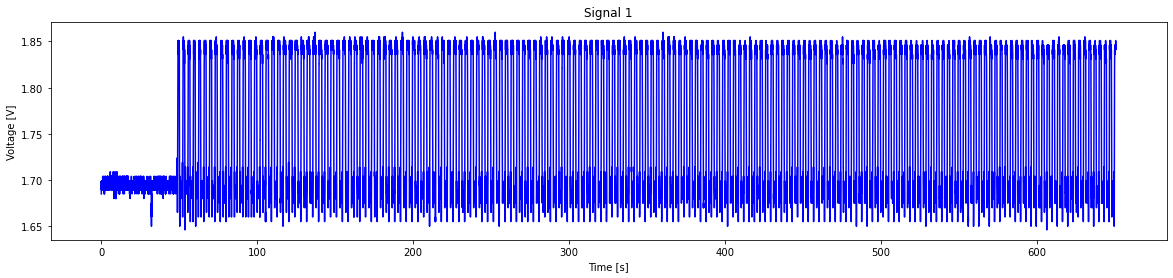

<Figure size 432x288 with 0 Axes>

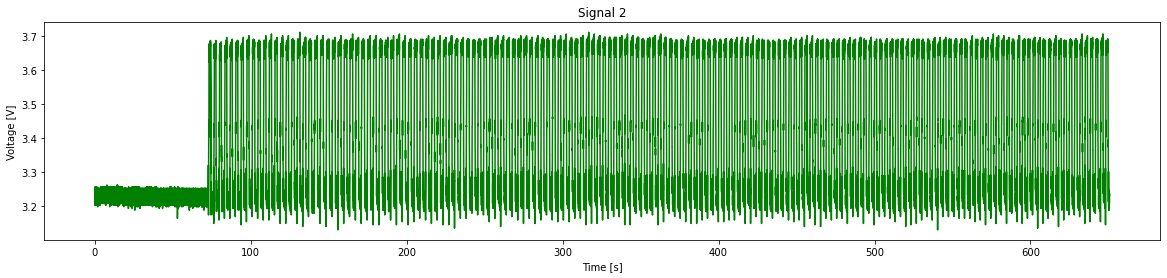

In [2]:
#************************************
folder   = '../../T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'
name = '2-12_B-ol5-aq5'
#************************************

raw = True


sig1, sig2, t = ddt.read_LV(folder, filename)

### Resample data

Text(0.5, 1.0, 'Signal 2')

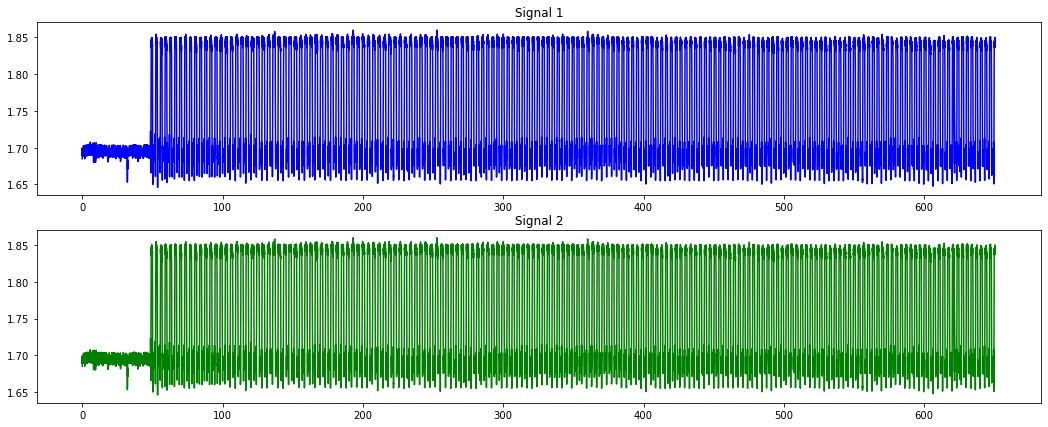

In [3]:
dt = 0.01 # sampling time

if raw:
    sig1, new_t = ddt.resample(sig1, t, dt=dt)
    sig2, _ = ddt.resample(sig2, t, dt=dt)
    t = new_t
    raw = False
else:
    print('data already resampled')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')

axs[1].plot(t, sig1, color='green')
axs[1].set_title('Signal 2')


## Fourier transformation


In [4]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 10000   # higher cut-off frequency

### Signal 1 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


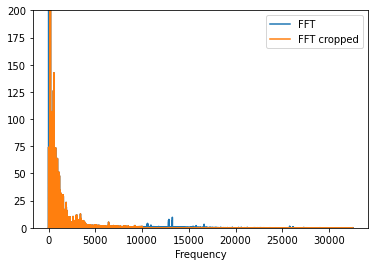

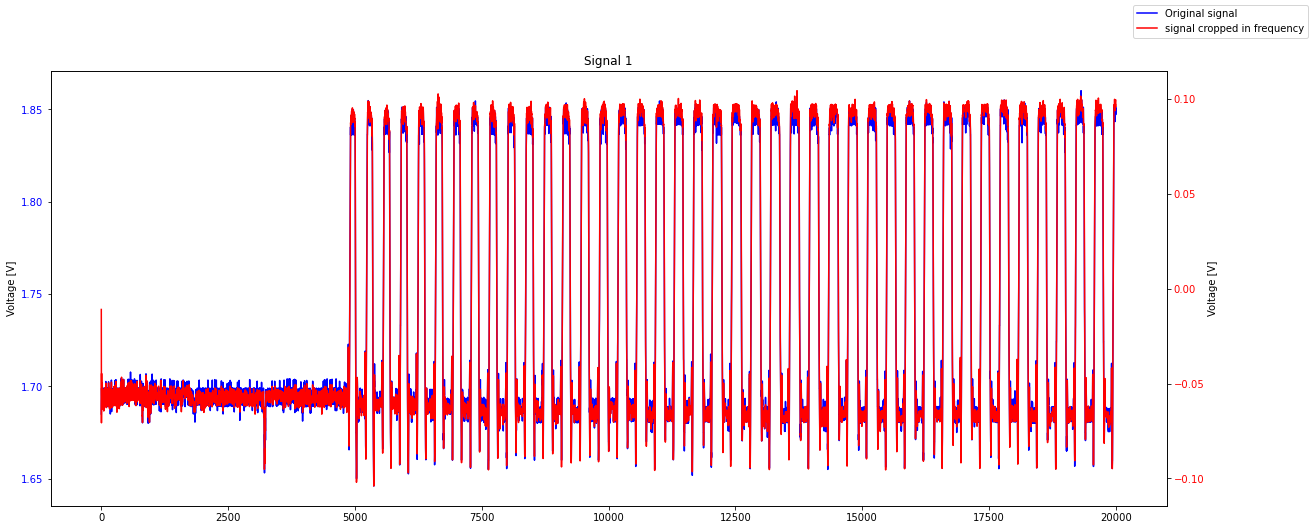

In [5]:
# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

x_min = 0       # signal plot x min.
x_max = 20000   # signal plot x max.
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


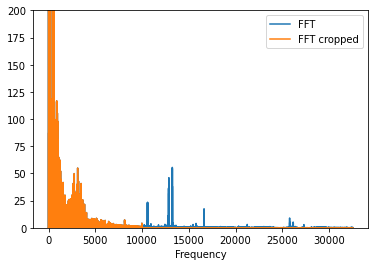

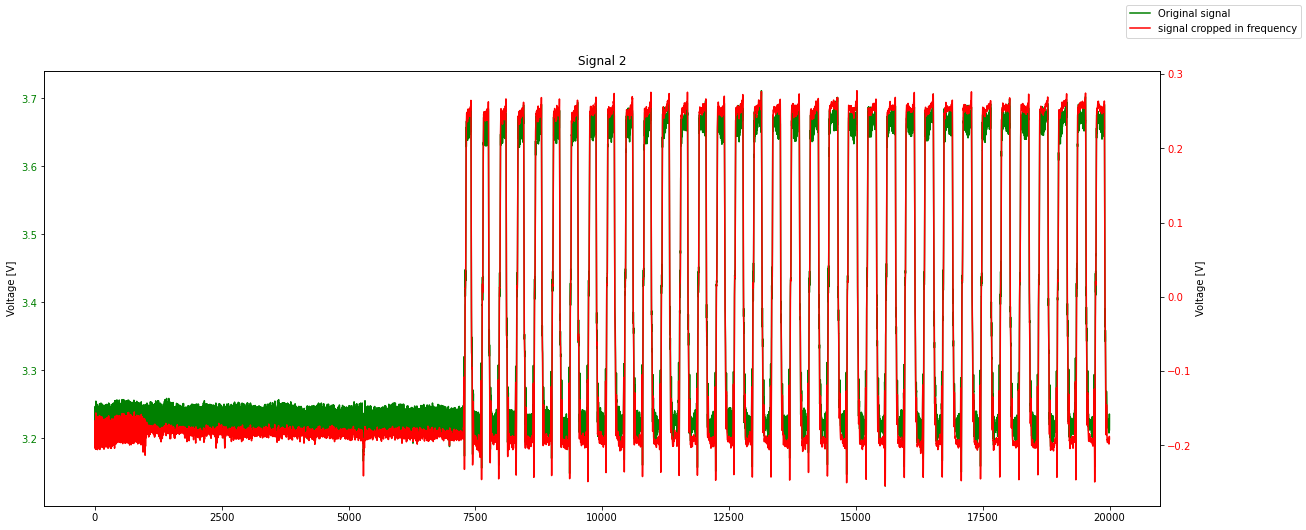

In [6]:
# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)

x_min = 0    # Plot x min.
x_max = 20000  # Plot x max. 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()

## Thresholds computing

modified the output of the function, to get also sigma_high and sigma_low

In [7]:
def thr_searcher(Ydata, nbins=20, low_sigmas=3, high_sigmas=5, plot_switch=True, Xdata=None, ymin=None, ymax=None, c01=None, c02=None, **kwargs):
    
    '''
    Description:
        Oscillating data finds the two threshold to identify peaks (droplets)
    
    Params:
        - Ydata:       array with oscillating data
        - nbins:       number of bins for the histogram to find the two thresholds
        - low_sigmas:  number of sigmas above the low mean where to put the lower thr
        - high_sigmas: number of sigmas below the high mean where to put the higher thr
        - plot_switch: if True shows plots
        - Xdata:       array with the matching time (or space) to the data
        - ymin, ymax:  ylims for the plot
        
    Returns:
        thr_low, thr_high
    '''
    
    xlabel = kwargs.pop('xlabel',None)
    ylabel = kwargs.pop('ylabel',None)
    
    if xlabel is None:
        xlabel = 'position [mm]'
    if ylabel is None:
        ylabel = 'luminosity'
    
    if plot_switch:
        #plt.clf() # Clear figure
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        freq,bins,p = axes[0].hist(Ydata, nbins, **kwargs)
    
    # Histogram definition
    else:
        freq,bins,p = plt.hist(Ydata, nbins, color='green')
    x = 0.5 *(bins[:-1] + bins[1:])
    max_freq = np.max(freq)                                     
        
    # Gaussian 1
    gauss1 = GaussianModel(prefix='g1_')
    pars   = gauss1.make_params(center=x[0]+(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq))

    # Gaussian 2
    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())
    
    if c01 is None:
        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        #pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)
    else:
        pars['g1_center'].set(value = c01)

    # Gaussian 2 parameters
    if c02 is None:
        c02 = x[-1]-(x[-1]-x[0])/10
        
    pars['g2_center'].set(value=c02)
    pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
    pars['g2_amplitude'].set(value=max(freq))

    mod  = gauss1 + gauss2
    init = mod.eval(pars, x=x)
    out  = mod.fit(freq, pars, x=x)

    
    if plot_switch:
        # Plot histo
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel(ylabel)
        axes[0].set_ylabel("Number of events")
        
        if axes[0].get_ylim()[1] > 1.5*max_freq:
            axes[0].set_ylim(0,1.5*max_freq)

    center2 = out.best_values.get('g2_center')
    sigma2  = out.best_values.get('g2_sigma')
    center1 = out.best_values.get('g1_center')
    sigma1  = out.best_values.get('g1_sigma')

    
    max_freq1 = max(freq[x<center1+sigma1])
    x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
    max_freq2 = max(freq[x>center2-sigma2])
    a         = x > center2-sigma2
    freq2     = np.zeros(len(freq))
    for i in range(len(a)): 
        if a[i]==True: freq2[i]=freq[i]
    x_max2 = x[np.argmax(freq2)]
       
    # Thresholds computing
    thr_low  = x_max1 + low_sigmas *sigma1
    thr_high = x_max2 - high_sigmas*sigma2
    
    # Signal plot
    if plot_switch:
        axes[0].vlines([thr_low], *axes[0].get_ylim(), color='cyan')
        axes[0].vlines([thr_high], *axes[0].get_ylim(), color='yellow')
        
        if Xdata is None:
            Xdata = np.arange(len(Ydata))
        
        axes[1].plot(Xdata, Ydata, **kwargs)
        axes[1].plot(thr_high*np.ones(len(Xdata)), color='yellow', label='thr_high')
        axes[1].plot(thr_low *np.ones(len(Xdata)), color='cyan', label='thr_low')
        plt.legend()
        plt.xlim((0, Xdata[len(Xdata)-1]))
        if not (ymin is None or ymax is None):
            axes[1].set_ylim(ymin, ymax)
        axes[1].set_title("Signal with thresholds")
        axes[1].set_xlabel(xlabel)
        axes[1].set_ylabel(ylabel)
        
    if thr_low > thr_high:
        print('WARNING: thr_low > thr_high')
    
    return thr_low, thr_high, sigma1, sigma2

### Signal 1

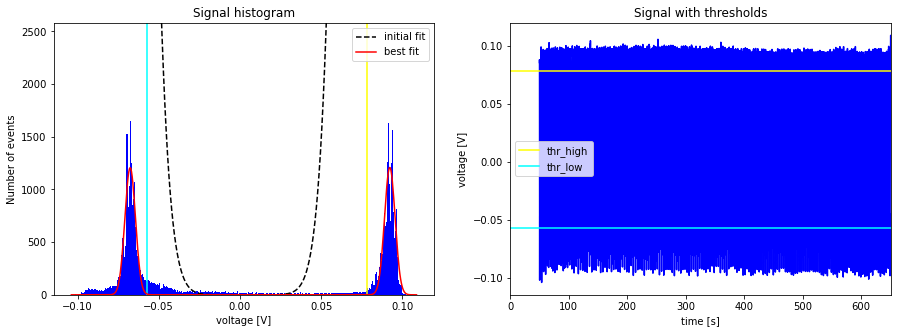

In [8]:
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = thr_searcher(sig1_high[5000:], 500, high_sigmas=4, low_sigmas=3, 
                                          Xdata=t[5000:], color='blue', xlabel='time [s]', ylabel='voltage [V]')

In [ ]:
%matplotlib notebook
thr_low_1, thr_high_1 = ddt.thr_searcher(sig1_high[5000:], 500, high_sigmas=4, low_sigmas=3, Xdata=t[5000:],
                                         color='blue', xlabel='time [s]', ylabel='voltage [V]')

### Signal 2

In [ ]:
thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = thr_searcher(sig2_high[8000:], 1000, high_sigmas=4, low_sigmas=8, Xdata=t[8000:],
                                         color='green', xlabel='time [s]', ylabel='voltage [V]')

In [ ]:
thr_low_2, thr_high_2 = ddt.thr_searcher(sig2_high[8000:], 1000, high_sigmas=4, low_sigmas=8, Xdata=t[8000:],
                                         color='blue', xlabel='time [s]', ylabel='voltage [V]')

## Drops detection

In [ ]:
#new drop detection: narrow_start, narrow_end, wide_start, wide end

def drop_det_new(Xdata, Ydata, thr_low, thr_high, plot_switch=True, ymin=None, ymax=None, xrange=None, **kwargs):
    
    '''
    Description:
        Identifies the start and end position of the droplets in the narrow and wide range
    
    Params:
        - Xdata:             array with time (space)
        - Ydata:             array with the voltage/luminosity values
        - thr_low, thr_high: threshold computed with 'thr_seracher'
        - plot_switch:       if True shows plots
        - ymin, ymax:        ylims for the plot
        - xrange:            width of the window to be shown (expressed in time/space units)
        
    Returns:
        narrow_start, narrow_end, wide_start, wide_end : arrays with starts and ends of the droplets
                                                         They have always the same lenght and *_start[0] < *_end[0],
                                                         i.e. no spurious detections
    '''
    
    # Masks
    bool_high  = Ydata > thr_high
    bool_low   = Ydata < thr_low
    
    #first cycle finds narrow_start. 
    #drop_ends are detected when drop goes below thr_low.
    #we don't need them, but they are necessary to the correct narrow_start detection
    #narrow_start is what we previously called drop_start, drop_end is the old drop_end
    narrow_start = [0]
    drop_end   = [1]
   
    for i in range(len(Ydata)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if narrow_start[-1] < drop_end[-1] and i > drop_end[-1]:
                narrow_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if narrow_start[-1] > drop_end[-1] and i > narrow_start[-1]:
                drop_end.append(i)
                
    #second cycle finds narrow_end. Now we call ascent_start the point where the drop goes beyond thr_low.
    ascent_start=[0]
    narrow_end=[1]
    
    for i in range(len(Ydata)-1):
        
        if bool_low[i]==True and bool_high[i]==False and bool_low[i+1]==False:
            if ascent_start[-1] < narrow_end[-1] and i > narrow_end[-1]:
                ascent_start.append(i)
                
        elif bool_low[i]==False and bool_high[i]==True and bool_high[i+1]==False  :
            if i > ascent_start[-1]:
                if ascent_start[-1] > narrow_end[-1]:
                    narrow_end.append(i)
                else: 
                    narrow_end[-1]=i      #make sure to take the real narrow_end, not just a fluctuation in the middle of the drop
                
                
    # Selection
    narrow_start = narrow_start[1:]
    narrow_end   = narrow_end[1:]
    ascent_start = ascent_start[1:]
    drop_end     = drop_end[1:] 
    # Cropping
    if len(narrow_start) > len(narrow_end):
        narrow_start = narrow_start[:-1] 
    print(len(narrow_start), len(narrow_end))
                
    #find wide_start and wide_end. Only need low thr:
    #check whenever signal simply overcomes low threshold and stores those indices
    # wide start: last spike that goes beyond low threshold before ascent_start
    # wide_end: first spike to go below low threshold after drop_end
    
    spike_start=[]
    spike_end=[]
    wide_start=[]
    wide_end=[]
    
    for i in range(len(Ydata)-1):
        if bool_low[i]==True and bool_low[i+1]==False:
            spike_start.append(i)
        elif bool_low[i]==False and bool_low[i+1]==True:
            spike_end.append(i)
            
    spike_start = np.array(spike_start)
    spike_end = np.array(spike_end)
    
    b=0    
    for start,end in list(zip(narrow_start,narrow_end)):
        #print(start,end)
        a = spike_start[spike_start<start][-2]        
        wide_start.append(a)
        if b>a: print(t[start],'s: LOWER THRESHOLD TOO LOW')
        if len(spike_end[spike_end>end])>1:
            b = spike_end[spike_end>end][1]
            wide_end.append(b)
        
    #cropping
    if len(wide_start) > len(wide_end):
        wide_start = wide_start[:-1] 
    if len(narrow_start)>len(wide_start):
        narrow_start = narrow_start[:-1] 
        narrow_end = narrow_end[:-1] 
        
    print(len(narrow_start), len(narrow_end))
    
    # Number acquisition -> time [s] conversion
#     narrow_start = Xdata[narrow_start]
#     narrow_end   = Xdata[narrow_end]
#     wide_start   = Xdata[wide_start]
#     wide_end     = Xdata[wide_end]
    
    # Plotting 
    if plot_switch:
        if xrange is None:
            xrange = Xdata[-1]
        for j in range(int (Xdata[-1]/xrange)):
            fig, ax = plt.subplots(figsize=(20,4))
            plt.plot(Xdata, Ydata, **kwargs)
            
            if ymin is None or ymax is None:
                ymin, ymax = ax.get_ylim()
            else:
                plt.ylim(ymin, ymax)
            
            for i in range(len(narrow_end)):

                plt.vlines(Xdata[narrow_start[i]], ymin, ymax, color='green')
                plt.vlines(Xdata[narrow_end[i]],   ymin, ymax, color='red')
                plt.vlines(Xdata[wide_start[i]],ymin, ymax, color='lime')
                plt.vlines(Xdata[wide_end[i]],ymin, ymax, color='orange')

            plt.ylabel("Luminosity")
            plt.xlabel("Position [mm]")
            plt.xlim(j*xrange,(j+1)*xrange)
            plt.plot(thr_high*np.ones(len(Xdata)), color='yellow')
            plt.plot(thr_low *np.ones(len(Xdata)), color='cyan')
            plt.show()    
    
        
    return np.array(narrow_start), np.array(narrow_end), np.array(wide_start), np.array(wide_end)

### Signal 1

In [ ]:
xrange       =    100    # single plot x range [s]
narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = drop_det_new(t, sig1_high, thr_low_1, thr_high_1,
                                                                        xrange=xrange, plot_switch=True)
#function modified to give output arrays in index form, not in seconds.

### Signal 2

In [ ]:
xrange       = 100           # single plot x range [s]
narrow_start_2, narrow_end_2, wide_start_2, wide_end_2= drop_det_new(t, sig2_high, thr_low_2, thr_high_2,
                                                                        xrange=xrange, plot_switch=True)
#function modified to give output arrays in index form, not in seconds.

## Slope function

In [ ]:
# calculate slope around narrow_start and narrow_end
def slopes(Xdata, Ydata, narrow_start, narrow_end, start_range, end_range):

    def lin_func(x,a,b):
        return a*x + b
    
    slope_start = []
    slope_end   = []
    
    fig, ax = plt.subplots(figsize=(13,6))
    ax.plot(Xdata[:9000],Ydata[:9000], color='blue', alpha = 0.5)
    
    for n_start, n_end in list(zip(narrow_start,narrow_end)):
        x = Xdata[n_start-start_range:n_start+start_range]
        y = Ydata[n_start-start_range:n_start+start_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_start.append(popt[0])
        #example plot
        if n_start<9000:
            fit_curve = lin_func(x,*popt)
            ax.plot(x, fit_curve, color='green')
        
        x = Xdata[n_end-end_range:n_end+end_range]
        y = Ydata[n_end-end_range:n_end+end_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_end.append(popt[0])
        if n_start<9000:
            fit_curve = lin_func(x,*popt)
            ax.plot(x, fit_curve, color='red')
    
            
    return np.array(slope_start), np.array(slope_end)


In [ ]:
slope_start_1, slope_end_1=slopes(t,sig1_high, narrow_start_1, narrow_end_1, start_range=3, end_range = 3)


In [ ]:
slope_start_2, slope_end_2=slopes(t,sig2_high, narrow_start_2, narrow_end_2, start_range=3, end_range = 3)

In [ ]:
list(zip(slope_start_1, slope_end_1))

In [ ]:
v_err_1 = sigma_high_1
t_err_1 = v_err_1/slope_start_1

In [ ]:
t_err_1